[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rohitgandikota/sliders/blob/main/demo_concept_sliders.ipynb)

In [2]:
import torch
from PIL import Image
import argparse
import os, json, random
import pandas as pd
import matplotlib.pyplot as plt
import glob, re

from safetensors.torch import load_file
import matplotlib.image as mpimg
import copy
import gc
from transformers import CLIPTextModel, CLIPTokenizer

import diffusers
from diffusers import DiffusionPipeline
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel, LMSDiscreteScheduler
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor, AttentionProcessor
from typing import Any, Dict, List, Optional, Tuple, Union
from trainscripts.textsliders.lora import LoRANetwork, DEFAULT_TARGET_REPLACE, UNET_TARGET_REPLACE_MODULE_CONV
from diffusers.pipelines.stable_diffusion_xl import StableDiffusionXLPipelineOutput

In [3]:
# my implement of encode_prompt
from diffusers.loaders import FromSingleFileMixin, LoraLoaderMixin, TextualInversionLoaderMixin
from diffusers.utils import (
    is_accelerate_available,
    is_accelerate_version,
    is_invisible_watermark_available,
    logging,
    randn_tensor,
    replace_example_docstring,
)
logger = logging.get_logger(__name__)  # pylint: disable=invalid-name

def my_encode_prompt(
        self,
        prompt: str,
        prompt_2: Optional[str] = None,
        device: Optional[torch.device] = None,
        num_images_per_prompt: int = 1,
        do_classifier_free_guidance: bool = True,
        negative_prompt: Optional[str] = None,
        negative_prompt_2: Optional[str] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        lora_scale: Optional[float] = None,
        text_encoder=None,
        text_encoder_2=None
    ):
        device = device or self._execution_device

        # set lora scale so that monkey patched LoRA
        # function of text encoder can correctly access it
        
        # My implementation
        print(f"my_encoder_prompt loar_scale : {lora_scale}")
        self.text_encoder = text_encoder if text_encoder is not None else self.text_encoder
        self.text_encoder_2 = text_encoder_2 if text_encoder_2 is not None else self.text_encoder_2
        
        if lora_scale is not None and isinstance(self, LoraLoaderMixin):
            self._lora_scale = lora_scale

        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        # Define tokenizers and text encoders
        tokenizers = [self.tokenizer, self.tokenizer_2] if self.tokenizer is not None else [self.tokenizer_2]
        text_encoders = (
            # [self.text_encoder, self.text_encoder_2] if self.text_encoder is not None else [self.text_encoder_2]
            [self.text_encoder, self.text_encoder_2] if self.text_encoder is not None else [self.text_encoder_2]

        )

        if prompt_embeds is None:
            prompt_2 = prompt_2 or prompt
            # textual inversion: procecss multi-vector tokens if necessary
            prompt_embeds_list = []
            prompts = [prompt, prompt_2]
            for prompt, tokenizer, text_encoder in zip(prompts, tokenizers, text_encoders):
                if isinstance(self, TextualInversionLoaderMixin):
                    prompt = self.maybe_convert_prompt(prompt, tokenizer)

                text_inputs = tokenizer(
                    prompt,
                    padding="max_length",
                    max_length=tokenizer.model_max_length,
                    truncation=True,
                    return_tensors="pt",
                )

                text_input_ids = text_inputs.input_ids
                untruncated_ids = tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

                if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                    text_input_ids, untruncated_ids
                ):
                    removed_text = tokenizer.batch_decode(untruncated_ids[:, tokenizer.model_max_length - 1 : -1])
                    logger.warning(
                        "The following part of your input was truncated because CLIP can only handle sequences up to"
                        f" {tokenizer.model_max_length} tokens: {removed_text}"
                    )

                prompt_embeds = text_encoder(
                    text_input_ids.to(device),
                    output_hidden_states=True,
                )

                # We are only ALWAYS interested in the pooled output of the final text encoder
                pooled_prompt_embeds = prompt_embeds[0]
                prompt_embeds = prompt_embeds.hidden_states[-2]

                prompt_embeds_list.append(prompt_embeds)

            prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)

        # get unconditional embeddings for classifier free guidance
        zero_out_negative_prompt = negative_prompt is None and self.config.force_zeros_for_empty_prompt
        if do_classifier_free_guidance and negative_prompt_embeds is None and zero_out_negative_prompt:
            negative_prompt_embeds = torch.zeros_like(prompt_embeds)
            negative_pooled_prompt_embeds = torch.zeros_like(pooled_prompt_embeds)
        elif do_classifier_free_guidance and negative_prompt_embeds is None:
            negative_prompt = negative_prompt or ""
            negative_prompt_2 = negative_prompt_2 or negative_prompt

            uncond_tokens: List[str]
            if prompt is not None and type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt, negative_prompt_2]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = [negative_prompt, negative_prompt_2]

            negative_prompt_embeds_list = []
            for negative_prompt, tokenizer, text_encoder in zip(uncond_tokens, tokenizers, text_encoders):
                if isinstance(self, TextualInversionLoaderMixin):
                    negative_prompt = self.maybe_convert_prompt(negative_prompt, tokenizer)

                max_length = prompt_embeds.shape[1]
                uncond_input = tokenizer(
                    negative_prompt,
                    padding="max_length",
                    max_length=max_length,
                    truncation=True,
                    return_tensors="pt",
                )

                negative_prompt_embeds = text_encoder(
                    uncond_input.input_ids.to(device),
                    output_hidden_states=True,
                )
                # We are only ALWAYS interested in the pooled output of the final text encoder
                negative_pooled_prompt_embeds = negative_prompt_embeds[0]
                negative_prompt_embeds = negative_prompt_embeds.hidden_states[-2]

                negative_prompt_embeds_list.append(negative_prompt_embeds)

            negative_prompt_embeds = torch.concat(negative_prompt_embeds_list, dim=-1)

        prompt_embeds = prompt_embeds.to(dtype=self.text_encoder_2.dtype, device=device)
        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]
            negative_prompt_embeds = negative_prompt_embeds.to(dtype=self.text_encoder_2.dtype, device=device)
            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

        pooled_prompt_embeds = pooled_prompt_embeds.repeat(1, num_images_per_prompt).view(
            bs_embed * num_images_per_prompt, -1
        )
        if do_classifier_free_guidance:
            negative_pooled_prompt_embeds = negative_pooled_prompt_embeds.repeat(1, num_images_per_prompt).view(
                bs_embed * num_images_per_prompt, -1
            )

        return prompt_embeds, negative_prompt_embeds, pooled_prompt_embeds, negative_pooled_prompt_embeds

In [4]:
import inspect
import os
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from diffusers.pipelines import StableDiffusionXLPipeline
import random

import torch
from transformers import CLIPTextModel, CLIPTextModelWithProjection, CLIPTokenizer

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    
@torch.no_grad()
def call(
        self,
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        denoising_end: Optional[float] = None,
        guidance_scale: float = 5.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
        original_size: Optional[Tuple[int, int]] = None,
        crops_coords_top_left: Tuple[int, int] = (0, 0),
        target_size: Optional[Tuple[int, int]] = None,
        negative_original_size: Optional[Tuple[int, int]] = None,
        negative_crops_coords_top_left: Tuple[int, int] = (0, 0),
        negative_target_size: Optional[Tuple[int, int]] = None,
    
        network:LoRANetwork=None, 
        warn_up_steps=None,
        scale=None,
        unet=None,
        text_encoder=None,
        text_encoder_2=None,
    ):
        # 0. Default height and width to unet
        height = height or self.default_sample_size * self.vae_scale_factor
        width = width or self.default_sample_size * self.vae_scale_factor

        original_size = original_size or (height, width)
        target_size = target_size or (height, width)
        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            prompt_2,
            height,
            width,
            callback_steps,
            negative_prompt,
            negative_prompt_2,
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
        )

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        # my implement
        network.set_lora_slider(scale=0)
        with network:    
            self.encode_prompt = my_encode_prompt
            (
                original_prompt_embeds,
                original_negative_prompt_embeds,
                original_pooled_prompt_embeds,
                original_negative_pooled_prompt_embeds,
            ) = self.encode_prompt(
                self=self,
                prompt=prompt,
                prompt_2=prompt_2,
                device=device,
                num_images_per_prompt=num_images_per_prompt,
                do_classifier_free_guidance=do_classifier_free_guidance,
                negative_prompt=negative_prompt,
                negative_prompt_2=negative_prompt_2,
                prompt_embeds=prompt_embeds,
                negative_prompt_embeds=negative_prompt_embeds,
                pooled_prompt_embeds=pooled_prompt_embeds,
                negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
                lora_scale=scale,
                text_encoder=text_encoder,
                text_encoder_2=text_encoder_2
            )
        original_prompt_embeds = copy.copy(original_prompt_embeds)
        original_negative_prompt_embeds = copy.copy(original_negative_prompt_embeds)
        original_pooled_prompt_embeds = copy.copy(original_pooled_prompt_embeds)
        original_negative_pooled_prompt_embeds = copy.copy(original_negative_pooled_prompt_embeds)
        
        network.set_lora_slider(scale=scale)
        with network:
            self.encode_prompt = my_encode_prompt
            (
                prompt_embeds,
                negative_prompt_embeds,
                pooled_prompt_embeds,
                negative_pooled_prompt_embeds,
            ) = self.encode_prompt(
                self=self,
                prompt=prompt,
                prompt_2=prompt_2,
                device=device,
                num_images_per_prompt=num_images_per_prompt,
                do_classifier_free_guidance=do_classifier_free_guidance,
                negative_prompt=negative_prompt,
                negative_prompt_2=negative_prompt_2,
                prompt_embeds=prompt_embeds,
                negative_prompt_embeds=negative_prompt_embeds,
                pooled_prompt_embeds=pooled_prompt_embeds,
                negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
                lora_scale=scale,
                text_encoder=text_encoder,
                text_encoder_2=text_encoder_2
            )
        
        print(sum(original_prompt_embeds), sum(prompt_embeds))
        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)

        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Prepare added time ids & embeddings
        add_text_embeds = pooled_prompt_embeds
        add_time_ids = self._get_add_time_ids(
            original_size, crops_coords_top_left, target_size, dtype=prompt_embeds.dtype
        )
        if negative_original_size is not None and negative_target_size is not None:
            negative_add_time_ids = self._get_add_time_ids(
                negative_original_size,
                negative_crops_coords_top_left,
                negative_target_size,
                dtype=prompt_embeds.dtype,
            )
        else:
            negative_add_time_ids = add_time_ids

        if do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
            original_prompt_embeds = torch.cat([original_negative_prompt_embeds, original_prompt_embeds], dim=0)
            original_add_text_embeds = torch.cat([original_negative_pooled_prompt_embeds, original_pooled_prompt_embeds], dim=0)
            add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)

        prompt_embeds = prompt_embeds.to(device)
        add_text_embeds = add_text_embeds.to(device)
        original_prompt_embeds = original_prompt_embeds.to(device)
        original_add_text_embeds = original_add_text_embeds.to(device)
        add_time_ids = add_time_ids.to(device).repeat(batch_size * num_images_per_prompt, 1)

        # 8. Denoising loop
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)

        # 7.1 Apply denoising_end
        if denoising_end is not None and isinstance(denoising_end, float) and denoising_end > 0 and denoising_end < 1:
            discrete_timestep_cutoff = int(
                round(
                    self.scheduler.config.num_train_timesteps
                    - (denoising_end * self.scheduler.config.num_train_timesteps)
                )
            )
            num_inference_steps = len(list(filter(lambda ts: ts >= discrete_timestep_cutoff, timesteps)))
            timesteps = timesteps[:num_inference_steps]
        latents = latents.to(unet.dtype)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if i<warn_up_steps:
                    tmp_prompt_embeds = original_prompt_embeds
                    tmp_add_text_embeds = original_add_text_embeds
                else:
                    tmp_prompt_embeds = prompt_embeds
                    tmp_add_text_embeds = add_text_embeds
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                added_cond_kwargs = {"text_embeds": tmp_add_text_embeds, "time_ids": add_time_ids}
                with network:
                    noise_pred = unet(
                        latent_model_input,
                        t,
                        encoder_hidden_states=tmp_prompt_embeds,
                        cross_attention_kwargs=cross_attention_kwargs,
                        added_cond_kwargs=added_cond_kwargs,
                        return_dict=False,
                    )[0]

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                if do_classifier_free_guidance and guidance_rescale > 0.0:
                    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=guidance_rescale)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        if not output_type == "latent":
            # make sure the VAE is in float32 mode, as it overflows in float16
            needs_upcasting = self.vae.dtype == torch.float16 and self.vae.config.force_upcast

            if needs_upcasting:
                self.upcast_vae()
                latents = latents.to(next(iter(self.vae.post_quant_conv.parameters())).dtype)

            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]

            # cast back to fp16 if needed
            if needs_upcasting:
                self.vae.to(dtype=torch.float16)
        else:
            image = latents

        if not output_type == "latent":
            # apply watermark if available
            if self.watermark is not None:
                image = self.watermark.apply_watermark(image)

            image = self.image_processor.postprocess(image, output_type=output_type)

        # Offload all models
#         self.maybe_free_model_hooks()

        if not return_dict:
            return (image,)

        return StableDiffusionXLPipelineOutput(images=image)

In [5]:
device = 'cuda:0'
StableDiffusionXLPipeline.__call__ = call
pipe = StableDiffusionXLPipeline.from_pretrained('stabilityai/stable-diffusion-xl-base-1.0')

# pipe.__call__ = call
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
lora_weights =[
    'models/smile_slider_alphaNone_rank4_noxattn_clip/smile_slider_alphaNone_rank4_noxattn_clip_last.pt'
]

In [7]:
prompts = [
    'Image of a person, realistic, 8k',
#     'A realistic picture of a person',
#     'A realistic photograph of a person, bokeh, blurred background, 8k',
#     'Professional headshot of a person',
#     'closeup photo of a person on city street, realistic, 8k'
#     "Astronaut in a jungle holding an umbrella, cold color palette, muted colors, detailed, 8k",
    
]

Image of a male person, realistic, 8k 19114


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

LoRANetwork
create LoRA for Clip: 88 modules.
my_encoder_prompt loar_scale : 0
my_encoder_prompt loar_scale : 0
tensor([[-3.8926, -2.5137,  4.7148,  ...,  0.1897,  0.4182, -0.2971],
        [ 0.2034,  0.8398,  0.8521,  ..., -0.2739,  0.1995,  0.3389],
        [-0.0576,  0.2356,  0.6431,  ...,  0.2295,  0.4714,  0.8652],
        ...,
        [ 0.8193, -0.3784, -0.0718,  ...,  0.5020,  0.2578,  0.4502],
        [ 0.8149, -0.3687, -0.0790,  ...,  0.3486,  0.0833,  0.3850],
        [ 0.7793, -0.3828, -0.0401,  ...,  0.3950,  0.1724,  0.3767]],
       device='cuda:0', dtype=torch.float16) tensor([[-3.8926, -2.5137,  4.7148,  ...,  0.1897,  0.4182, -0.2971],
        [ 0.2034,  0.8398,  0.8521,  ..., -0.2739,  0.1995,  0.3389],
        [-0.0576,  0.2356,  0.6431,  ...,  0.2295,  0.4714,  0.8652],
        ...,
        [ 0.8193, -0.3784, -0.0718,  ...,  0.5020,  0.2578,  0.4502],
        [ 0.8149, -0.3687, -0.0790,  ...,  0.3486,  0.0833,  0.3850],
        [ 0.7793, -0.3828, -0.0401,  ...,  0.3

  0%|          | 0/50 [00:00<?, ?it/s]

TypeError: 'AxesSubplot' object is not iterable

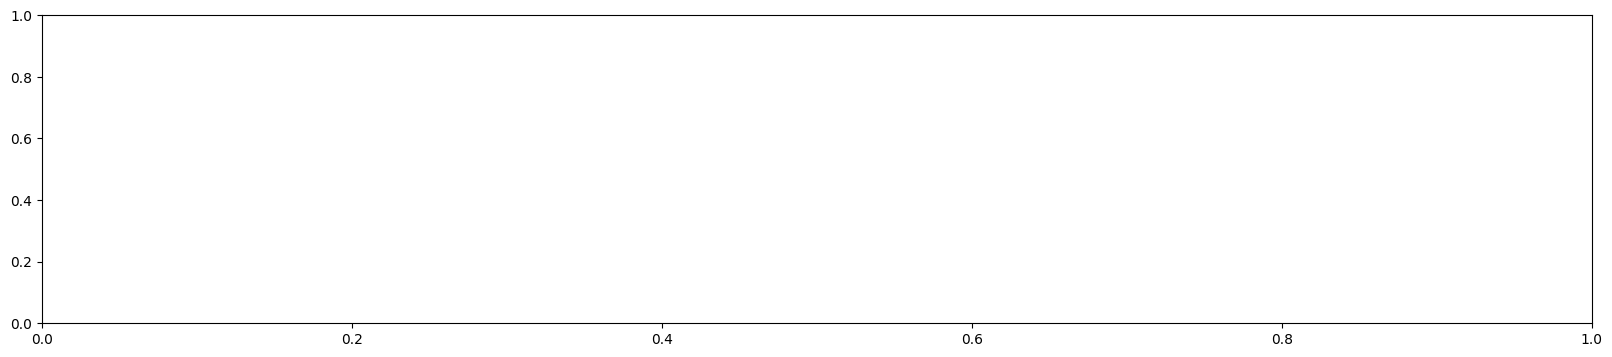

: 

In [9]:
weight_dtype = torch.float16
warn_up_steps = 5
num_images_per_prompt = 1
scales = [ 0]
prompt=prompts[-1]
seed = 19110
print(prompt, seed)
lora_weight = lora_weights[-1]
pipe = StableDiffusionXLPipeline.from_pretrained('stabilityai/stable-diffusion-xl-base-1.0', torch_dtype=weight_dtype)

# pipe.__call__ = call
pipe = pipe.to(device)
unet = pipe.unet
if 'full' in lora_weight:
    train_method = 'full'
elif 'noxattn' in lora_weight:
    train_method = 'noxattn'
else:
    train_method = 'noxattn'

network_type = "c3lier"
if train_method == 'xattn':
    network_type = 'lierla'

TEXT_ENCODER_TARGET_MODULES = ["q_proj", "v_proj"]

modules = TEXT_ENCODER_TARGET_MODULES
if network_type == "c3lier":
    modules += UNET_TARGET_REPLACE_MODULE_CONV
import os
model_name = lora_weight

name = os.path.basename(model_name)
rank = 4
alpha = 1

network = LoRANetwork(
        torch.nn.Sequential(pipe.text_encoder, pipe.text_encoder_2),
        rank=rank,
        multiplier=1.0,
        alpha=alpha,
        train_method=train_method,
        lora_type="clip",
    ).to(device, dtype=weight_dtype)
network.load_state_dict(torch.load(lora_weight))


image_list = []
for scale in scales:
    generator = torch.manual_seed(seed)
    with network:
        images = pipe(prompt, num_images_per_prompt=1, num_inference_steps=50, generator=generator, network=network, warn_up_steps=warn_up_steps, scale=scale, unet=unet, text_encoder=pipe.text_encoder,text_encoder_2=pipe.text_encoder_2).images[0]
    image_list.append(images)

del unet, network, pipe
unet = None
network = None
pipe = None
torch.cuda.empty_cache()
flush()


from pathlib import Path
import os
prefix = Path("/home/twei/Pictures/generated")
tmp_prompt = prompts[-1].replace(" ","_")
prefix /= f"{tmp_prompt}_{seed}_suprised_clip"
os.makedirs(prefix, exist_ok=True)
for scale, image in zip(scales, image_list):
    name = prefix / f"{scale}.jpg"
    image.save(name)

fig, ax = plt.subplots(1, len(image_list), figsize=(20,4))
for i, a in enumerate(ax):
    a.imshow(image_list[i])
    a.set_title(f"{scales[i]}",fontsize=15)
    a.axis('off')

plt.suptitle(f'{os.path.basename(lora_weight)}', fontsize=20)
# plt.tight_layout()
plt.show()

In [ ]:

#LPIPS
import torch
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
lpips = LearnedPerceptualImagePatchSimilarity(net_type="alex", normalize=True)
from PIL import Image
import torchvision.transforms as transforms

def transform_images(image):
	transform = transforms.Compose([transforms.ToTensor(),])
	tensor_image = torch.stack([transform(image)])
	return tensor_image
def compute_lpips(original, imgs):
	result = []
	for img in imgs:
		result.append(lpips(transform_images(original), transform_images(img)))
	print(result)
	with open(prefix/"lpips.txt", "w") as file:
		for element in result:
			file.write(str(element)+"\n")

compute_lpips(image_list[2], image_list)

IndexError: list index out of range